# [INFO-H515 - Big Data Scalable Analytics](http://uv.ulb.ac.be/course/view.php?id=74317?username=guest)


## TP 3 - K-means

#### *Yann-Aël Le Borgne, Jacopo De Stefani and Gianluca Bontempi*

####  02/05/2018


This class aims at implementing a widely used clustering algorithm - K-means - in Map/Reduce. We will first review the centralised approach, and then explore two approaches: one based on a Map/Reduce of rows (as was done in TP2), and an optimised version based on a Map/Reduce of partitions. We finally cover the implementation using the Spark MLlib library. 

The techniques will first be aplied to an artificial dataset (a mixture of gaussian, for which the number of clusters (gaussians) is known), and then on an image compression task.


### Class objectives:

* Implementation of centralised K-means from scratch using numpy
* Implementation of K-means in Map/Reduce, on rows
* Implementation of K-means in Map/Reduce, on RDD partitions 
* Application for image compression
* Implementation with Spark MLlib


# K-means

K-means is a classic clustering algorithm which aims to partition $N$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest centroid, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. https://en.wikipedia.org/wiki/K-means_clustering.

![](./img/ExampleCluster.png)

### Notations

* Let $x_i$, $1 \le i \le N$, be a set of $N$ observations, with $x_i \in \mathbb{R}^n$. 
* Let $X$ be the matrix of observations with rows $x_i$, of size $N \times n$ ($N$ observations, (rows) and $n$ features (columns)). 
* Let $k$ be the number of clusters, and $\mu_j \in \mathbb{R}^n$, $1 \le j \le k$ be the cluster means (also called cluster centroids).

The k-means problem seeks to find a set of $k$ centroids $M = \{\mu_1, . . . , \mu_k\}$ which minimize the function

$$
L(X, M)=\sum_{i,j} (x_i-\mu_j)^2
$$

The standard algorithm for solving k-means uses an iterative process which guarantees a decrease in total error (value of the objective function L(M)) on each step. The algorithm is as follows:

1. Initialise $\{\mu_1,..., \mu_k\}$ with k random observations from the set $X$. Initialise $k$ sets $S_j=\{\}$.
2. For each point $x \in X$, find the closest centroid $\mu_j$ and add $x$ to the set $S_j$.
3. For $j \in \{1,...k\}$, set $\mu_j$ to be the centroid of the points in $S_j$.
4. Repeat steps 2 and 3 until the centroids have converged.



# General imports

In [1]:
import time
import os 
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


# 1) Dataset generation

Let us first generate an artificial dataset of $N$ observations with $n$ variables drawn from a mixture of k gaussians.

In [2]:
def genData(N,n,k,random_seed):
    
    start = time.time()

    np.random.seed(random_seed)   

    #Set centroid centers along a diagonal, and fix cov matrix to identity
    M=np.array([range(k),]*n).transpose()*5
    cov=np.identity(n)

    X=np.empty((N,n))

    for i in range(N):
        j=np.random.randint(0,k)
        X[i,:]=np.random.multivariate_normal(M[j,:],cov)
    
        
    print("Number of observations :",N)
    print("Number of features :",n)

    print("Dimension of X :",X.shape)
    print("Number of clusters :",k)
    
    end = time.time()
    print("Time to create artificial data: ",round(end - start,2),"seconds")
    
    return (X,M)

In [3]:
#Let us generate the dataset
N=100
n=2
k=3
(X,M)=genData(N,n,k,1)

Number of observations : 100
Number of features : 2
Dimension of X : (100, 2)
Number of clusters : 3
Time to create artificial data:  0.14 seconds


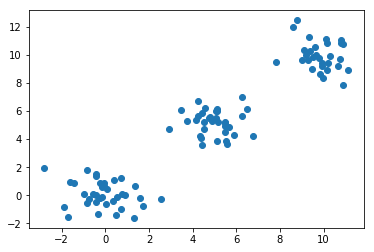

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(X[:,0], X[:,1])


# 2) K-means - centralised approach


Let us recall the algorithm:

1. Initialise $\{\mu_1,..., \mu_k\}$ with k random observations from the set $X$. Initialise $k$ sets $S_j=\{\}$.
2. For each point $x \in X$, find the closest centroid $\mu_j$ and add $x$ to the set $S_j$.
3. For $j \in \{1,...k\}$, set $\mu_j$ to be the centroid of the points in $S_j$.
4. Repeat steps 2 and 3 until the centroids have converged.

Below is an implementation of this algorithm

In [16]:
#Input
#X: Matrix of observations
#k: Number of clusters
#T: Number of iterations
#Output:
#M_sequence: List of cluster centroids at each iteration
#S: List of $S_j$ at the last iteration
def centralizedKmeans(X,k=3,T=10,random_seed=0):

    #Initialise centroids with the k random observations from X
    np.random.seed(random_seed)
    
    index_init=np.random.choice(X.shape[0],k,replace=False)
    M=X[index_init,:].tolist()
    #Keep track of all cluster centroids updates for plotting later the sequence of updates
    M_sequence=[M]

    #Initial loss
    L_sequence=[]

    for t in range(T):
        #Associate each to its closest centroid
        S=assignXToCluster(X,M)
        #Update centroid means
        M=np.array([np.mean(s,axis=0) for s in S])
    
        #Add update to M sequence for plotting
        M_sequence.append(M)
        #Add loss to L sequence for plotting
        #L_sequence.append(computeLoss(S,M))
        
    return (M_sequence, S, L_sequence)

The function S=assignXToCluster(X,M) takes the matrix of observations X and the set of centroids M, and returns a list of list where element j is the set of observations $S_j$ falling into cluster j. This is for the second step of the algorithm.

In [6]:
#Function that assigns all observations in X to their closest cluster centroids
#Input:
#* X: Array of observations
#* M: List of cluster centroids
#Output: 
#* S: List of observations falling in each cluster (list of list)
def assignXToCluster(X,M):
    #Number of observations
    N=X.shape[0]
    #Number of clusters is length of M
    k=len(M)
    #Initialise sets of observations belonging to each cluster
    S = [[] for i in range(k)]
    
    #For each observation
    for i in range(N):
        #Get closest centroid
        c_i=closestCentroid(X[i,:],M)
        #Add observation to corresponding cluster
        S[c_i].append(X[i,:])
    
    return S
  

**Exercise:**

Write the function closestCentroid(x,M), that takes as input an observation x and the set of centroids M, and returns the index of the closest centroid to x in M.

In [7]:
#Function that finds the closest cluster centroid for x
#M is the list of cluster centroids
#Returns index of closest centroid to x
def closestCentroid(x,M):
    dist=[]
    #Number of clusters is length of M
    k=len(M)
    for i in range(k):
        dist.append(np.linalg.norm(x-M[i]))
        
    #Get closest entroid
    closest_centroid=dist.index(min(dist))
    
    return closest_centroid

**Exercise:**

Run the algorithm with k=3 clusters, and T=10 iterations 

In [8]:
X[0:10,:]

array([[  4.45025382,   3.59712728],
       [  5.48349585,   5.18843661],
       [  1.74481176,  -0.7612069 ],
       [ -0.85990661,   1.77260763],
       [  5.67723401,   4.89312157],
       [ 11.13376944,   8.90010873],
       [  5.17532267,   5.19443089],
       [  0.53381091,  -0.0919733 ],
       [  4.36889167,   4.09265664],
       [ -0.42645009,   1.3814073 ]])

In [9]:
(M_sequence, S, L_sequence)=centralizedKmeans(X,k=3,T=10)

#### Print and plot the results

In [10]:
#Let M be the centroids found in the last iteration
M=M_sequence[-1]
print("Centroids found:", M)

Centroids found: [[ 4.98401302  5.1847767 ]
 [ 9.83695066  9.9504322 ]
 [-0.08083014  0.09678886]]


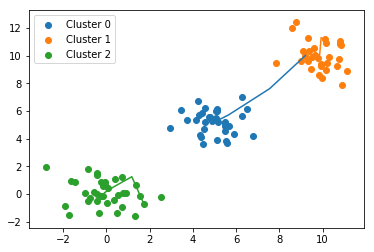

In [11]:
fig, ax = plt.subplots(figsize=(6,4))

#Plot clusters and sequences of updates for centroids
for j in range(k):
    Xc=np.array(S[j])
    ax.scatter(Xc[:,0], Xc[:,1], label='Cluster '+str(j))

    #Add sequence of updates for centroids
    sequence_centroid=np.array(M_sequence)[:,j,:]
    ax.plot(sequence_centroid[:,0],sequence_centroid[:,1])
ax.legend()

#### Compute the loss at each iteration

For a given set of cluster centroids M, the loss is the mean squared error between observations in each cluster, and its cluster centroid

**Exercise:**
    
Write a function L=computeLoss(S,M), that takes as input the set of observations falling in each cluster, and the set of centroids, and returns the loss L (sum of the squared distances between all observations and their closest centroid).

In [12]:
#S is a list whose elements are the observations falling into cluster i
#M is the list of centroids
#L :loss
def computeLoss(S,M):
    k=len(M)
    L=0
    for j in range(k):
        #Loss for cluster j
        Lj=0
        for i in range(len(S[j])):
            Lj=Lj+np.linalg.norm(S[j][i]-M[j])**2
        L=L+Lj
    return L
    

In [14]:
# Uncomment L_sequence computation in centralizedKmeans
(M_sequence, S, L_sequence)=centralizedKmeans(X,k=3,T=10)

In [15]:
L_sequence

[913.74887954692531,
 382.35790494056835,
 169.82135672044436,
 169.82135672044436,
 169.82135672044436,
 169.82135672044436,
 169.82135672044436,
 169.82135672044436,
 169.82135672044436,
 169.82135672044436]

# 3) K-means - Map/Reduce approach


If $X$ does not fit in memory, a Map/Reduce approach can be designed to distribute the computation of updates for the centroids. K-means has two main steps:

1. Associate each observation to its closest centroid, and 
2. Update cluster centroids

Before reading below, take a moment to think of how these two steps can be computed in a Map/Reduce manner. 

The first step requires to compute the distance between each observation, and all cluster centroids. This can be done using the `map` operator, by applying the `closestCentroid` function to each observation. The function will be slightly modified to return a (key,value) pair where the key will be the index of the closest centroid, and the value a pair (observation,1) which will allow the computation of the mean. 

The second step consists in taking the mean of the observations falling in each cluster, which can be done using the `reduceByKey` followed by the `mapValues` operators. 

**Summary of the sequence of operations with the Map/Reduce model**:

* **Stage 1**: Partitioning. Partition $X$ in $B$ blocks $X_k$, $1 \le k \le B$. This is done implicitly by Spark Resilient Distributed Dataset (RDDs). 
* **Stage 2**: Compute closest centroid for each observation using map operator
* **Stage 3**: Compute the mean of observations per cluster. As there is no 'mean' operator, this is a two step process where 1) the sum and number of observations per cluster (key) are computed with the reduceByKey  sum operator, and the mean is then computed by dividing the sum of obversations by their number using the mapValues function (which acts on the values of the grouping).
* **Stage 4**: Collect the updated means, and repeat stage 2 and 3 until convergence.



### Spark initialisation

In [17]:
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=2g  pyspark-shell"

from pyspark.sql import SparkSession

#Start Spark session with local master and 2 cores
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("KMeans") \
    .getOrCreate()
    
sc=spark.sparkContext

Below is the Map/Reduce adaptation of the centralizedKmeans

**Exercise:**

Fill the <FILLIN1> part, to reduce S in cluster centroids, and number of observations per cluster

In [18]:
#Input
#X_RDD: RDD of observations
#k: Number of clusters
#T: Number of iterations
#Output:
#M_sequence: List of cluster centroids at each iteration
#S: List of $S_j$ at the last iteration
def MR_Kmeans(X_RDD,k=3,T=10):

    #Initialise centroids with k observations from X
    M=X_RDD.takeSample(False,k)

    #Keep track of all cluster centroids updates for plotting later the sequence of updates
    M_sequence=[M]

    #Initial loss
    L_sequence=[]

    for t in range(T):
        #Associate each observation to its closest centroid. A (key,value) pair is returned, where the key is the 
        #cluster ID of the closest centroid,
        #and the value is a pair (x,1) that will allow to compute the sum and number of observations in each cluster 
        
        ################
        #<TOFILL1>
        S=X_RDD.map(lambda x: (closestCentroid(x,M),(x,1)))
        ################
        
        #Use reduceByKey operator to compute sum and number of observations in each cluster 
        #<TOFILL1>
        M_sum=S.reduceByKey(lambda v1,v2:(v1[0]+v2[0],v1[1]+v2[1]))
        #Use sum and number of observations in each cluster to compute mean of observations per cluster. 
        M_mean=M_sum.mapValues(lambda v: v[0]/v[1])
        #Finally sort by key (cluster IDs), and retrieve values (updated centroid means)
        M=M_mean.sortByKey().values().collect()
        M_sequence.append(M)
        #Compute loss
        L_sequence.append(MRcomputeLoss(S,M))

    return (M_sequence, S, L_sequence)

In [19]:
#Transforms X in an RDD with B partitions
B=4
X_RDD=sc.parallelize(X,B)

In [21]:
(M_sequence, S, L_sequence)=MR_Kmeans(X_RDD,k=3,T=10)

In [22]:
#Let M be the centroids found in the last iteration
M=np.array(M_sequence[-1])
print("Centroids found:", M)

Centroids found: [[  8.94588629  10.41187699]
 [ 10.02674143   9.33490924]
 [  2.26131785   2.45057447]]


**Exercise:**

The computation of the loss (L_sequence.append(computeLoss(S,M))) is still centralised. How could it be written in a Map/Reduce way?

Hint: The process is similar to that of computing the centroids, except that insted of taking the mean of the observations, we take the sum of the distance between observations of the cluster centroid.

In [20]:
def MRcomputeLoss(S,M):
    squared_dist=S.map(lambda key_value: (key_value[0],np.linalg.norm(key_value[1][0]-M[key_value[0]])**2))
    Lj_sum=squared_dist.reduceByKey(lambda v1,v2:v1+v2)
    Lj_list=Lj_sum.sortByKey().values().collect()
    L=np.sum(np.array(Lj_list))
    return L

In [26]:
# Uncomment L_sequence computation in MR_Kmeans
(M_sequence, S, L_sequence)=MR_Kmeans(X_RDD,k=3,T=10)

In [27]:
L_sequence

[1026.3145091461158,
 1017.6282733495252,
 1014.3477871646527,
 1012.6482995670831,
 1010.1026568790472,
 1008.1290185728599,
 947.3628792717376,
 486.80754377710065,
 170.76758854856854,
 169.82135672044436]

In [28]:
#Let M be the centroids found in the last iteration
M=np.array(M_sequence[-1])
print("Centroids found:", M)

Centroids found: [[-0.08083014  0.09678886]
 [ 9.83695066  9.9504322 ]
 [ 4.98401302  5.1847767 ]]


# Application to image compression

In this section, we will apply K-means to image compression. The intuition here is that we can use clustering to find a small number of colors that are most representative of the image, and map the original 24-bit colors to a lower-dimensional color space using the cluster assignments. Here's the image we're going to compress.

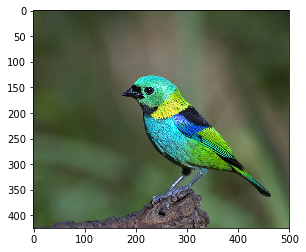

In [29]:
from PIL import Image
image=Image.open('img/bird.jpg')
image_original=np.asarray(image)
plt.imshow(image_original)

In [30]:
#The image is 425*500 pixels, with 3 color channels
image_original.shape

(425, 500, 3)

In [31]:
#Let us reshape it as an array of colors
X=image_original.reshape(-1,3)
X.shape

(212500, 3)

In [32]:
#Example of entries. Color values are between 0 and 255, of type uint8
X[0:3,:]

array([[68, 86, 48],
       [67, 85, 47],
       [66, 83, 47]], dtype=uint8)

In [33]:
#Need to cast to float to avoid overflows with additions
X=X.astype(float)

In [34]:
#Transforms X in an RDD with B partitions
B=4
X_RDD=sc.parallelize(X,B)

In [35]:
%time (M_sequence, S, L_sequence)=MR_Kmeans(X_RDD,k=10,T=10)

CPU times: user 728 ms, sys: 147 ms, total: 875 ms
Wall time: 1min 55s


In [36]:
L_sequence

[249917272.63375431,
 219412076.48094365,
 175298569.25326613,
 132692091.71452126,
 112110496.32808535,
 106791891.61647479,
 104216977.7259884,
 102719004.20175663,
 101778889.69227681,
 101060970.39443982]

**Exercise**:

Transform `X_RDD` so that each row (color) in `X_RDD` is changed to its closest centroid, and store the result in `X_compressed`

In [37]:
M=np.array(M_sequence[-1])
X_compressed=X_RDD.map(lambda x: (M[closestCentroid(x,M),:])).collect()

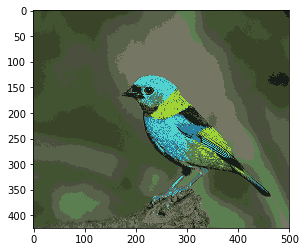

In [38]:
X_compressed=np.array(X_compressed,dtype=np.uint8)
image_compressed=X_compressed.reshape(425, 500, 3)
image_compressed = Image.fromarray(image_compressed)
plt.imshow(image_compressed)

# 4) Optimisation with mapPartitions

https://medium.com/dataholiks-distillery/l2-distance-matrix-vectorization-trick-26aa3247ac6c


In [39]:
def closestCentroidPartition(X,M):
    X=np.array(list(X))
    M=np.array(list(M))
    
    norm_x=np.sum(X**2,axis=1)
    norm_m=np.sum(M**2,axis=1)
    
    XM=np.dot(X,M.T)
    
    distances=-2 * XM + norm_m + norm_x[:, np.newaxis]
    
    closest_centroid=np.argmin(distances,axis=1)
    
    k=M.shape[0]
    M_sum=[]
    for i in range(k):
        id_cluster_i=np.where(closest_centroid==i)[0]
        X_i=X[id_cluster_i,:]
        print(X_i.shape)
        M_sum.append((i,(np.sum(X_i,axis=0),len(id_cluster_i))))
    
    return M_sum

In [40]:
#Input
#X_RDD: RDD of observations
#k: Number of clusters
#T: Number of iterations
#Output:
#M_sequence: List of cluster centroids at each iteration
#S: List of $S_j$ at the last iteration
def MR_Kmeans_Partitions(X_RDD,k=3,T=10):

    #Initialise centroids with k observations from X
    M=X_RDD.takeSample(False,k)

    #Keep track of all cluster centroids updates for plotting later the sequence of updates
    M_sequence=[M]

    #Initial loss
    L_sequence=[]

    for t in range(T):
        #Associate each observation to its closest centroid. A (key,value) pair is returned, where the key is the 
        #cluster ID, and the value is a pair (x,n) where x is the sum of values falling in the cluster for
        #each partition, and n the number of observations for that cluster in the partition
        S=X_RDD.mapPartitions(lambda X:closestCentroidPartition(X,M))
        #Use reduce operator to compute sum and number of observations in each cluster 
        #<TOFILL1>
        M_sum=S.reduceByKey(lambda v1,v2:(v1[0]+v2[0],v1[1]+v2[1]))
        #Use sum and number of observations in each cluster to compute mean of observations per cluster. 
        M_mean=M_sum.mapValues(lambda v: v[0]/v[1])
        #Finally sort by key (cluster IDs), and retrieve values (updated centroid means)
        M=M_mean.sortByKey().values().collect()
        M_sequence.append(M)
        #Compute loss (should be adapted for partitions)
        #L_sequence.append(MRcomputeLoss(S,M))

    return (M_sequence, S, L_sequence)

In [52]:
%time (M_sequence, S, L_sequence)=MR_Kmeans_Partitions(X_RDD,k=10,T=10)

CPU times: user 406 ms, sys: 70 ms, total: 476 ms
Wall time: 6.3 s


In [53]:
M=np.array(M_sequence[-1])
X_compressed=X_RDD.map(lambda x: (M[closestCentroid(x,M),:])).collect()

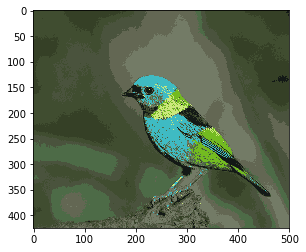

In [54]:
X_compressed=np.array(X_compressed,dtype=np.uint8)
image_compressed=X_compressed.reshape(425, 500, 3)
image_compressed = Image.fromarray(image_compressed)
plt.imshow(image_compressed)

# 5) K-means with Spark ML

See https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [44]:
from pyspark.ml.linalg import Vectors

X_tmp = map(lambda z: [Vectors.dense(z)],X)
X_DF = spark.createDataFrame(X_tmp,schema=["features"])

In [45]:
from pyspark.ml.clustering import KMeans

k=10
random_seed=0

# Trains a k-means model.
kmeans = KMeans(k=k,seed=random_seed,maxIter=1)

%time model = kmeans.fit(X_DF)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(X_DF)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
#print("Cluster Centers: ")
#for center in centers:
#    print(center)

CPU times: user 8.9 ms, sys: 1.44 ms, total: 10.3 ms
Wall time: 4.25 s
Within Set Sum of Squared Errors = 106401341.24919531


In [46]:
centers=np.array(centers,dtype=np.uint8)

In [47]:
X_compressed=X_RDD.map(lambda x: (centers[closestCentroid(x,centers),:])).collect()

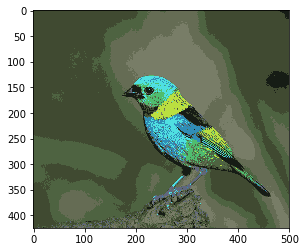

In [48]:
X_compressed=np.array(X_compressed)
image_compressed=X_compressed.reshape(425, 500, 3)
image_compressed = Image.fromarray(image_compressed)
plt.imshow(image_compressed)

# Relevant links

* http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise7.ipynb
* http://ai2-s2-pdfs.s3.amazonaws.com/23db/2d9c5a97f36f1b63ea249402b4be0919ebc9.pdf
* https://papers.nips.cc/paper/3150-map-reduce-for-machine-learning-on-multicore.pdf
* https://stanford.edu/~rezab/classes/cme323/S16/projects_reports/bodoia.pdf

# Acknowledgements

* Notebok inspired by http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise7.ipynb
